In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os

# Import your model classes - you'll need to copy these from your main file
# or import them if you've structured your code as modules
from main import PolicyNetwork, BrainTumorDataset, get_transforms, PPOAgent
# Alternatively, copy the PolicyNetwork class definition here

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[INFO] Using device: cpu


In [2]:
# Initialize the model architecture
input_channels = 4  # Adjust based on your data
model = PolicyNetwork(input_channels=input_channels).to(device)

# Load the saved weights
checkpoint_path = './checkpoints/best_policy.pt'  # Adjust path as needed
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
print(f"Model loaded successfully from {checkpoint_path}")

Model loaded successfully from ./checkpoints/best_policy.pt


In [5]:
# Set up your test dataset
DATA_PATH = 'data/content/data'
IMG_SIZE = (256, 256)

# load a single file for testing
test_transform = get_transforms(train=False, img_size=IMG_SIZE)

# Load a single test sample
test_files = [f for f in os.listdir(DATA_PATH) if f.endswith('.h5')]
single_file = test_files[0]  # Change index to test different files
print(f"Testing on file: {single_file}")

Testing on file: volume_54_slice_149.h5


In [6]:
# Create dataset with single file
test_ds = BrainTumorDataset(DATA_PATH, [single_file], transform=test_transform)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

# Get one sample
image, mask = next(iter(test_loader))
image, mask = image.to(device), mask.to(device)

# Perform inference
with torch.no_grad():
    policy_logits, value, seg_logits = model(image)
    
    # Get segmentation prediction
    seg_pred = F.softmax(seg_logits, dim=1)
    pred_mask = (seg_pred[:, 1:2] > 0.5).float()  # Binary mask from class 1
    
    # Get policy prediction
    policy_probs = F.softmax(policy_logits, dim=-1)
    
print(f"Policy probabilities: {policy_probs.cpu().numpy()}")
print(f"Predicted value: {value.cpu().numpy()}")
print(f"Prediction shape: {pred_mask.shape}")

Policy probabilities: [[0.6330057  0.36699426]]
Predicted value: [[0.00258545]]
Prediction shape: torch.Size([1, 1, 256, 256])


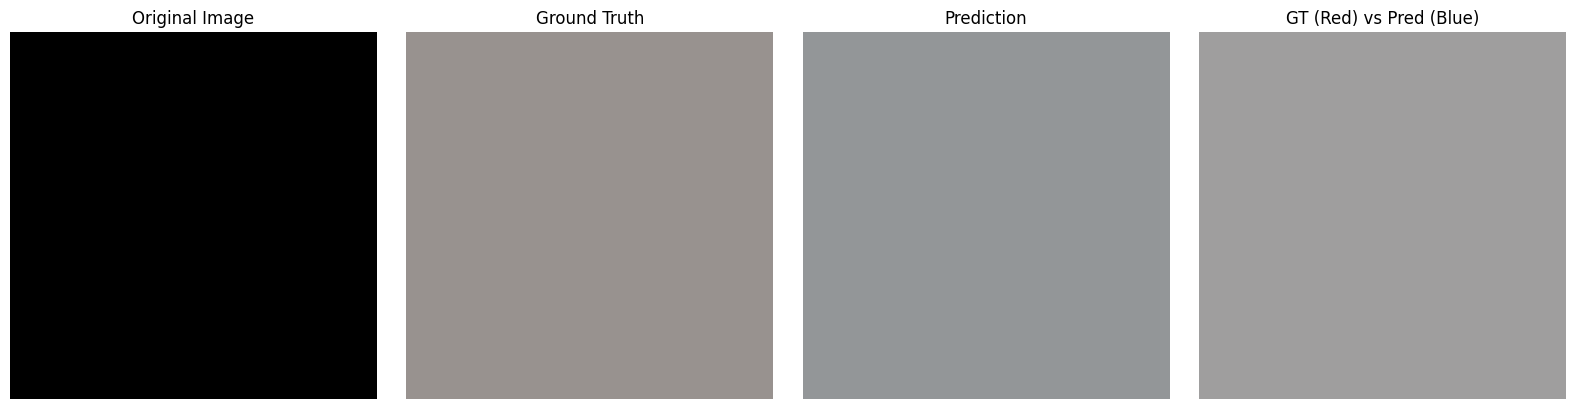

In [7]:
# Visualize the results
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Original image (first channel)
img_display = image[0, 0].cpu().numpy()
axes[0].imshow(img_display, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Ground truth mask
gt_mask = mask[0, 0].cpu().numpy()
axes[1].imshow(img_display, cmap='gray')
axes[1].imshow(gt_mask, cmap='Reds', alpha=0.6)
axes[1].set_title('Ground Truth')
axes[1].axis('off')

# Predicted mask
pred_np = pred_mask[0, 0].cpu().numpy()
axes[2].imshow(img_display, cmap='gray')
axes[2].imshow(pred_np, cmap='Blues', alpha=0.6)
axes[2].set_title('Prediction')
axes[2].axis('off')

# Overlay comparison
axes[3].imshow(img_display, cmap='gray')
axes[3].imshow(gt_mask, cmap='Reds', alpha=0.4, label='GT')
axes[3].imshow(pred_np, cmap='Blues', alpha=0.4, label='Pred')
axes[3].set_title('GT (Red) vs Pred (Blue)')
axes[3].axis('off')

plt.tight_layout()
plt.show()

In [8]:
# Calculate basic metrics for this single sample
def calculate_dice(pred, target, epsilon=1e-8):
    pred_bin = (pred > 0.5).float()
    target_bin = (target > 0.5).float()
    intersection = (pred_bin * target_bin).sum()
    union = pred_bin.sum() + target_bin.sum()
    dice = (2 * intersection + epsilon) / (union + epsilon)
    return dice.item()

def calculate_iou(pred, target, epsilon=1e-8):
    pred_bin = (pred > 0.5).float()
    target_bin = (target > 0.5).float()
    intersection = (pred_bin * target_bin).sum()
    union = ((pred_bin + target_bin) > 0).sum()
    iou = (intersection + epsilon) / (union + epsilon)
    return iou.item()

dice_score = calculate_dice(pred_mask, mask)
iou_score = calculate_iou(pred_mask, mask)

print(f"Dice Score: {dice_score:.4f}")
print(f"IoU Score: {iou_score:.4f}")
print(f"Tumor pixels in GT: {(mask > 0.5).sum().item()}")
print(f"Tumor pixels in Pred: {(pred_mask > 0.5).sum().item()}")

Dice Score: 1.0000
IoU Score: 1.0000
Tumor pixels in GT: 0
Tumor pixels in Pred: 0
